#### About this Notebook
In this notebook, we learn how to use scikit-learn to implement simple linear regression. We download a dataset that is related to fuel consumption and Carbon dioxide emission of cars. Then, we split our data into training and test sets, create a model using training set, Evaluate your model using test set, and finally use model to predict unknown value


### Importing Needed packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import math


## Understanding the Data

### `FuelConsumptionCo2.csv`:
We have a fuel consumption dataset, **`FuelConsumptionCo2.csv`**, which contains model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada. [Dataset source](http://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64)

- **MODELYEAR** e.g. 2014
- **MAKE** e.g. Acura
- **MODEL** e.g. ILX
- **VEHICLE CLASS** e.g. SUV
- **ENGINE SIZE** e.g. 4.7
- **CYLINDERS** e.g 6
- **TRANSMISSION** e.g. A6
- **FUEL CONSUMPTION in CITY(L/100 km)** e.g. 9.9
- **FUEL CONSUMPTION in HWY (L/100 km)** e.g. 8.9
- **FUEL CONSUMPTION COMB (L/100 km)** e.g. 9.2
- **CO2 EMISSIONS (g/km)** e.g. 182   --> low --> 0


## Reading the data in

In [2]:
df = pd.read_csv("FuelConsumptionCo2.csv")

# take a look at the dataset
df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


### Data Exploration
Lets first have a descriptive exploration on our data.

In [3]:
# summarize the data
df.describe()

,MODELYEAR,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
count,1067.0,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,2014.0,3.346298,5.794752,13.296532,9.474602,11.580881,26.441425,256.228679
std,0.0,1.415895,1.797447,4.101253,2.794510,3.485595,7.468702,63.372304
min,2014.0,1.000000,3.000000,4.600000,4.900000,4.700000,11.000000,108.000000
25%,2014.0,2.000000,4.000000,10.250000,7.500000,9.000000,21.000000,207.000000
50%,2014.0,3.400000,6.000000,12.600000,8.800000,10.900000,26.000000,251.000000
75%,2014.0,4.300000,8.000000,15.550000,10.850000,13.350000,31.000000,294.000000
max,2014.0,8.400000,12.000000,30.200000,20.500000,25.800000,60.000000,488.000000


In [4]:
# Lets select some features to explore more.
cdf = df[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB','CO2EMISSIONS']]
cdf.head()

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_COMB,CO2EMISSIONS
0,2.0,4,8.5,196
1,2.4,4,9.6,221
2,1.5,4,5.9,136
3,3.5,6,11.1,255
4,3.5,6,10.6,244


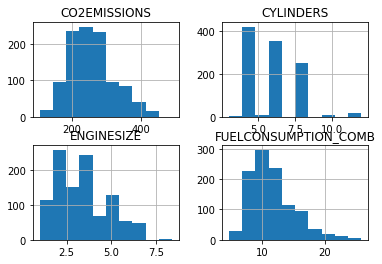

In [5]:
# we can plot each of these fearues.
viz = cdf[['CYLINDERS','ENGINESIZE','CO2EMISSIONS','FUELCONSUMPTION_COMB']]
viz.hist()
plt.show()

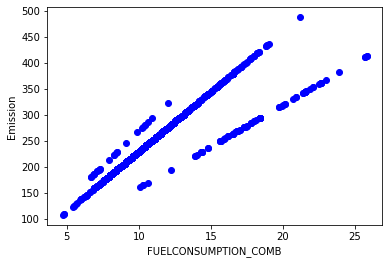

In [6]:
# Now, lets plot each of these features vs the Emission, to see how linear is their relation.
plt.scatter(cdf.FUELCONSUMPTION_COMB, cdf.CO2EMISSIONS,  color='blue')
plt.xlabel("FUELCONSUMPTION_COMB")
plt.ylabel("Emission")
plt.show()

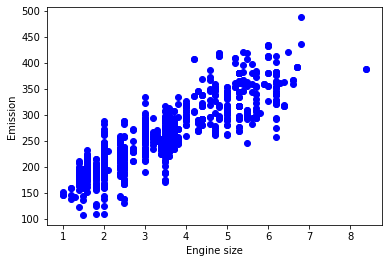

In [7]:
plt.scatter(cdf.ENGINESIZE, cdf.CO2EMISSIONS,  color='blue')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

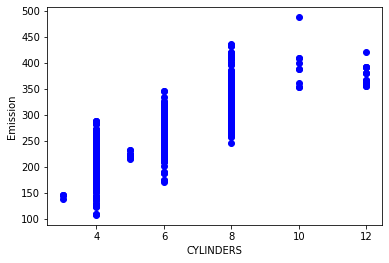

In [8]:
plt.scatter(cdf.CYLINDERS, cdf.CO2EMISSIONS,  color='blue')
plt.xlabel("CYLINDERS")
plt.ylabel("Emission")
plt.show()

From the above data visualizations, we can see that there is a direct relation between __Fuel Comsumption__ and __CO2__, __Engine Size__ and __CO2__, and __Number of Cylinders__ and __CO2__.

#### Creating train and test dataset
Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set. 
This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the data. It is more realistic for real world problems.

This means that we know the outcome of each data point in this dataset, making it great to test with! And since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it is truly an out-of-sample testing.

Lets split our dataset into train and test sets, 80% of the entire data for training, and the 20% for testing. We create a mask to select random rows using __np.random.rand()__ function: 

In [9]:
msk = np.random.rand(len(df)) < 0.8
train = cdf[msk]
test = cdf[~msk]

### Simple Regression Model
Linear Regression fits a linear model with coefficients B = (B1, ..., Bn) to minimize the 'residual sum of squares' between the independent x in the dataset, and the dependent y by the linear approximation. 

#### Train data distribution

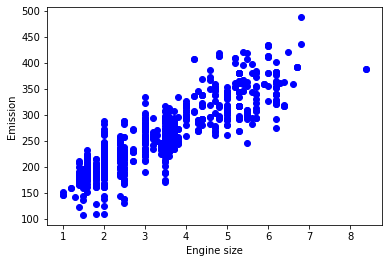

In [10]:
plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS,  color='blue')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

#### Modeling
Using sklearn package to model data to predict the amound of __CO2__ emission and __Engine Size__.

In [11]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['ENGINESIZE']])
train_y = np.asanyarray(train[['CO2EMISSIONS']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_[0])
print ('Intercept: ',regr.intercept_)

Coefficients:  [39.47495776]
Intercept:  [124.73890152]


As mentioned before, __Coefficient__ and __Intercept__ in the simple linear regression, are the parameters of the fit line. 
Given that it is a simple linear regression, with only 2 parameters, and knowing that the parameters are the intercept and slope of the line, sklearn can estimate them directly from our data. 
Notice that all of the data must be available to traverse and calculate the parameters.


#### Plot outputs

we can plot the fit line over the data:

Text(0, 0.5, 'Emission')

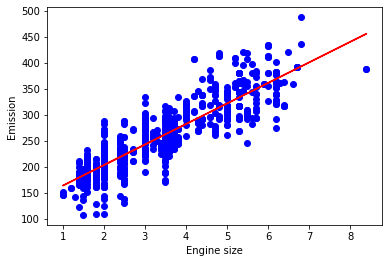

In [12]:
plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS,  color='blue')
plt.plot(train_x, regr.predict(train_x), '-r')
plt.xlabel("Engine size")
plt.ylabel("Emission")

#### Evaluation
we compare the actual values and predicted values to calculate the accuracy of a regression model. Evaluation metrics provide a key role in the development of a model, as it provides insight to areas that require improvement.

There are different model evaluation metrics, lets use MSE here to calculate the accuracy of our model based on the test set: 
    - Mean absolute error: It is the mean of the absolute value of the errors. This is the easiest of the metrics to understand since it’s just average error.
    - Mean Squared Error (MSE): Mean Squared Error (MSE) is the mean of the squared error. It’s more popular than Mean absolute error because the focus is geared more towards large errors. This is due to the squared term exponentially increasing larger errors in comparison to smaller ones.
    - Root Mean Squared Error (RMSE).
    - R-squared is not error, but is a popular metric for accuracy of your model. It represents how close the data are to the fitted regression line. The higher the R-squared, the better the model fits your data. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).


In [13]:
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['ENGINESIZE']])
test_y = nc(test[['CO2EMISSIONS']])

print("Mean absolute error: %.2f" % np.mean(np.absolute(regr.predict(test_x) - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((regr.predict(test_x) - test_y) ** 2))
print("R2-score: %.2f" % r2_score(regr.predict(test_x) , test_y) )

NameError: name 'nc' is not defined